In [1]:
%cd /kaggle/input/kcomfyui/KComfyUI/custom_nodes/GGUF
!pip install -r requirements.txt
%cd /kaggle/input/kcomfyui/KComfyUI/custom_nodes/ToSVG
!pip install -r requirements.txt

/kaggle/input/kcomfyui/KComfyUI/custom_nodes/GGUF
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.4/94.4 kB 2.9 MB/s eta 0:00:00
/kaggle/input/kcomfyui/KComfyUI/custom_nodes/ToSVG
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 19.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.0/20.0 MB 87.3 MB/s eta 0:00:00


In [2]:
%cd /kaggle/input/kcomfyui/KComfyUI
!pip install -r requirements.txt
!pip install cairosvg

/kaggle/input/kcomfyui/KComfyUI
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.2/61.2 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 305.2/305.2 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.8/34.8 MB 53.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.8/45.8 kB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 4.5 MB/s eta 0:00:00


In [3]:
import torch
from nodes import CheckpointLoaderSimple, CLIPTextEncode, KSampler, VAEDecode, SaveImage, EmptyLatentImage, DualCLIPLoader, VAELoader
from custom_nodes.GGUF.nodes import UnetLoaderGGUF
from custom_nodes.ToSVG.svgnode import ConvertRasterToVectorColor

import cairosvg
from IPython.display import Image 

In [4]:
checkpoint_loader = UnetLoaderGGUF()
model = checkpoint_loader.load_unet(unet_name='/kaggle/input/flux1-dev-q2_k/pytorch/default/2/flux1-dev-Q2_K.gguf')

clip_loader = DualCLIPLoader()
clip = clip_loader.load_clip(clip_name1='/kaggle/input/flux1-dev-q2_k/pytorch/default/2/t5xxl_fp8_e4m3fn.safetensors', clip_name2='/kaggle/input/flux1-dev-q2_k/pytorch/default/2/clip_l.safetensors', type='flux')

vae_loader =VAELoader()
vae = vae_loader.load_vae(vae_name='/kaggle/input/flux1-dev-q2_k/pytorch/default/2/ae.safetensors')

/kaggle/input/kcomfyui/KComfyUI/custom_nodes/GGUF/loader.py:65: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  torch_tensor = torch.from_numpy(tensor.data) # mmap



ggml_sd_loader:
 GGMLQuantizationType.F32      471
 GGMLQuantizationType.Q2_K     304
 GGMLQuantizationType.F16        5


In [5]:
import pandas as pd
train = pd.read_csv('/kaggle/input/drawing-with-llms/train.csv')

In [6]:
# prompt = 'A cute unicorn'
prompt = train.iloc[12]['description']
print(prompt)

# テキストのエンコード
clip_text_encode = CLIPTextEncode()
positive_conditioning = clip_text_encode.encode(
    text=f"flat vector logo icon of {prompt}. Sandra Boynton style",
    clip=clip[0],
)
negative_conditioning = clip_text_encode.encode(
    text="lurry image, thin line, shadows, blurry edges, messy background, text, letters",
    clip=clip[0],
)

# 潜在画像の生成
latent_encode = EmptyLatentImage()
latent_image = latent_encode.generate(width=256, height=256, batch_size=1)

# サンプリング
k_sampler = KSampler()
sampled_image = k_sampler.sample(
    model=model[0],
    seed=143091209577701,
    positive=positive_conditioning[0],
    negative=negative_conditioning[0],
    latent_image=latent_image[0],
    steps=6,
    cfg=1.0,
    sampler_name="euler",
    scheduler="simple",
    denoise=1.0,
)

# 画像のデコード
vae_decode = VAEDecode()
decoded_image = vae_decode.decode(samples=sampled_image[0], vae=vae[0])

# SVGコンバーター
svg_conv = ConvertRasterToVectorColor()
svg_output = svg_conv.convert_to_svg(
    image=decoded_image[0].detach(),
    hierarchical="cutout",
    mode="polygon",
    filter_speckle=4,
    color_precision=6,
    layer_difference=16,
    corner_threshold=60,
    length_threshold=4,
    max_iterations=10,
    splice_threshold=45,
    path_precision=3,
)

a starlit night over snow-covered peaks


  0%|          | 0/6 [00:00<?, ?it/s]

14954
[NG] SVG is too large!


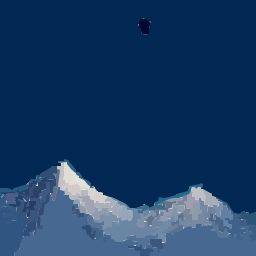

In [7]:
svg_start = svg_output[0][0].find('<svg')
svg = svg_output[0][0][svg_start:]

png_fromstring = cairosvg.svg2png(bytestring=svg)


max_svg_size: int = 10000
print(len(svg.encode('utf-8')))

if len(svg.encode('utf-8')) > max_svg_size:
    print("[NG] SVG is too large!")
else:
    print("[OK] SVG is within the limit.")

Image(png_fromstring)

In [8]:
del model,clip, vae

In [9]:
from transformers import AutoProcessor, AutoModel
model = AutoModel.from_pretrained("/kaggle/input/google-siglip-so400m-patch14-384/transformers/default/1")
processor = AutoProcessor.from_pretrained("/kaggle/input/google-siglip-so400m-patch14-384/transformers/default/1")

In [10]:
from PIL import Image

def svgMetric(prompt, svg):
    cairosvg.svg2png(svg, write_to="/kaggle/working/temp.png")
    image = Image.open('/kaggle/working/temp.png').convert("RGB")
    texts = ["SVG illustration of " + prompt]
    inputs = processor(text=texts, images=image, padding="max_length", return_tensors="pt")
    with torch.no_grad():
        outputs = model(**inputs)
    logits_per_image = outputs.logits_per_image
    probs = torch.sigmoid(logits_per_image)
    return probs[0][0].item()


print(prompt)
print("SCORE: {:.4f}".format(svgMetric(prompt, svg)))

a starlit night over snow-covered peaks
SCORE: 0.5782
